In [1]:
%%html
<style>
#notebook-container {
    width: 90%;
    background-color: #EEE
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #FFF
}

.code_cell .input {
    width: 50%;
    background-color: #FFF
}
</style>

リニアモータのモデルを使って評価，シミュレーションを行う。

が，とりあえず簡単な系にします。

In [3]:
clear all
A = [ 0 1 0; 0 0 1; 0 0 0];
B = [0;0;1];
C = [1 0 0];
ST = 0.030;
sys = ss(A,B,C,[]);
sysd = c2d(sys,ST)


sysd =
 
  A = 
            x1       x2       x3
   x1        1     0.03  0.00045
   x2        0        1     0.03
   x3        0        0        1
 
  B = 
            u1
   x1  4.5e-06
   x2  0.00045
   x3     0.03
 
  C = 
       x1  x2  x3
   y1   1   0   0
 
  D = 
       u1
   y1   0
 
サンプル時間:  0.03 seconds
離散時間状態空間モデル。




In [5]:
% sim setting
len = 200;
time = 0:ST:ST*(len-1);
x_gt = zeros(3,len);
x_obs = zeros(3,len); 
x_obs2 = zeros(3,len);

% noise variable 
sigma1 = 0.01;
Noise = [sigma1] .* randn(1,len);

% init
x_gt(:,1) = [1;-2;3];
x_obs(:,1) = [-1;2;-3]; % converted 
x_obs2(:,1) = [-1;2;-3]; % Non-converted
U = sin(1*pi/3*time);

In [10]:
bwbase = [1/sqrt(2)+1i/sqrt(2),1,1/sqrt(2)-1i/sqrt(2)];



bwbase =

   0.7071 + 0.7071i   1.0000 + 0.0000i   0.7071 - 0.7071i




In [23]:
final_err = zeros(20,3);

W = sigma1^2;
for lpole = 1:20
    Ks = place(sysd.A',sysd.A'*sysd.C',exp(ST*bwbase*-1*lpole))';
    Cnom=Ks*W*Ks';
    Pends = dlyap(sysd.A-Ks*sysd.C*sysd.A,Cnom);
    final_err(lpole,:)=diag(Pends)';
end

警告: 余分な凡例の入力を無視します。
> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)



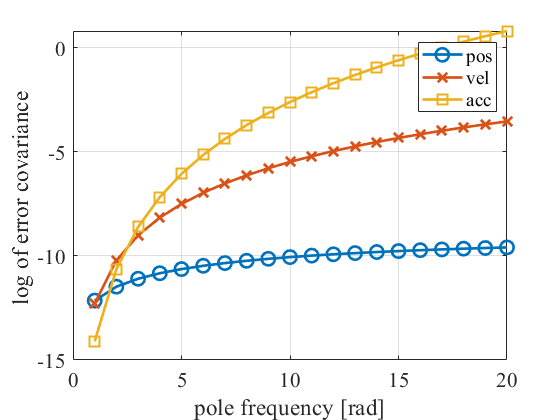

In [29]:
lpoles = 1:20;
figure(1)
plot(lpoles,log(final_err(:,1)),'o-',lpoles,log(final_err(:,2)),'x-',lpoles,log(final_err(:,3)),'s-')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos','vel','acc','Best')



sigma1 =

    0.1000

警告: 余分な凡例の入力を無視します。
> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)
警告: 余分な凡例の入力を無視します。
> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)



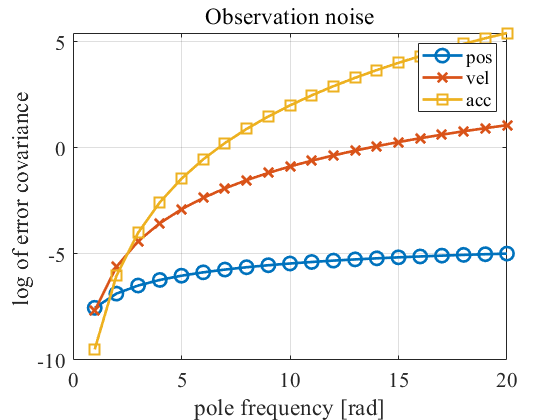

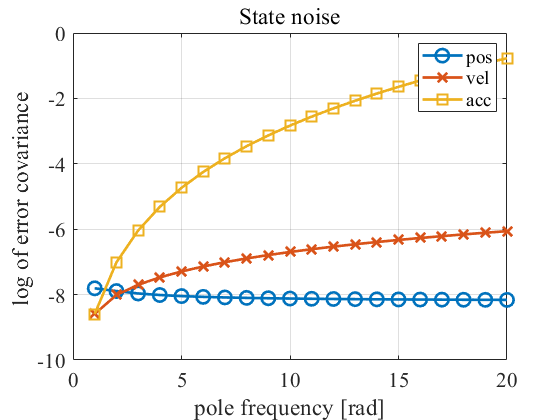

In [89]:
%%
P_obs_ = zeros(3,3,len);
F = -place(sysd.A,sysd.B,exp(ST*-0.5*bwbase));
%% 

sigma1 = 0.1
W = sigma1^2;


final_errex = zeros(20,6);
for lpole = 1:20
    Ks = place(sysd.A',sysd.A'*sysd.C',exp(ST*bwbase*-1*lpole))';
    Aex=[sysd.A+sysd.B*F -sysd.B*F;zeros(3) sysd.A-Ks*sysd.C*sysd.A];
    Kex = [0;0;0;-Ks];
    Cnomex=Kex*W*Kex';
    Pexends = dlyap(Aex,Cnomex);
    final_errex(lpole,:)=diag(Pexends)';
end

%%
figure(2)
% plot(final_errex(:,1:3))
grid on
plot(lpoles,log(final_errex(:,1)),'o-',lpoles,log(final_errex(:,2)),'x-',lpoles,log(final_errex(:,3)),'s-')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos','vel','acc','best')
title('State noise')
SaveFigPDF(2,'statenoise_pred')

figure(3)
% plot(final_errex(:,4:6))
grid on
plot(lpoles,log(final_errex(:,4)),'o-',lpoles,log(final_errex(:,5)),'x-',lpoles,log(final_errex(:,6)),'s-')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos','vel','acc','best')
title('Observation noise')
SaveFigPDF(3,'obsnoise_pred')


In [43]:
final_errex(:,4:6)


ans =

    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000
    0.0000    0.0001    0.0002
    0.0000    0.0003    0.0008
    0.0000    0.0006    0.0023
    0.0000    0.0009    0.0058
    0.0000    0.0015    0.0125
    0.0000    0.0022    0.0243
    0.0000    0.0031    0.0436
    0.0000    0.0041    0.0737
    0.0000    0.0054    0.1182
    0.0000    0.0070    0.1818
    0.0001    0.0087    0.2700
    0.0001    0.0108    0.3892
    0.0001    0.0131    0.5467
    0.0001    0.0157    0.7506
    0.0001    0.0185    1.0102
    0.0001    0.0217    1.3357
    0.0001    0.0252    1.7385
    0.0001    0.0290    2.2306




Observation的にはゲインを下げたほうがより良い推定結果を生むというのがわかる。
しかし，FBを含めた制御ではそうとも限らない。

```
Ks 20 では
0.0001    0.0013    0.0092
    0.0013    0.0301    0.2579
    0.0092    0.2579    2.3913
    
Ks 1
OBS
1.0e-03 *
    0.0053   -0.0124   -0.0139
   -0.0124    0.9443    0.8081
   -0.0139    0.8081    0.6945

Xe
1.0e-27 *

    0.1443   -0.0641   -0.0200
   -0.0641    0.0285    0.0089
   -0.0200    0.0089    0.0028

Loop400
Ks 20
Pinf =

    0.0001    0.0011    0.0077
    0.0011    0.0294    0.2426
    0.0077    0.2426    2.2456
    

Pxinf =

   1.0e-27 *

    0.4004   -0.1157   -0.0934
   -0.1157    0.0334    0.0270
   -0.0934    0.0270    0.0218
```

In [40]:

%% simulation loop
simloop = 300;
Ks = place(sysd.A',sysd.A'*sysd.C',exp(ST*bwbase*-1*1))';

x_obs_loop = zeros(3,simloop);
e_obs_loop = zeros(3,simloop);

for j = 1:simloop
Noise = [sigma1] .* randn(1,len);

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*F*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i)+Noise(:,i);

    x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*F*x_obs(:,i-1) + sysd.B*U(:,i);
    yobs_hat = sysd.C * x_obs_hat;
    x_obs(:,i) = x_obs_hat + Ks*(y-yobs_hat);
end
x_obs_loop(:,j) = x_gt(:,end); 
e_obs_loop(:,j) = x_gt(:,end)-x_obs(:,end); 
end


j =

     1


j =

     2


j =

     3


j =

     4


j =

     5


j =

     6


j =

     7


j =

     8


j =

     9


j =

    10


j =

    11


j =

    12


j =

    13


j =

    14


j =

    15


j =

    16


j =

    17


j =

    18


j =

    19


j =

    20


j =

    21


j =

    22


j =

    23


j =

    24


j =

    25


j =

    26


j =

    27


j =

    28


j =

    29


j =

    30


j =

    31


j =

    32


j =

    33


j =

    34


j =

    35


j =

    36


j =

    37


j =

    38


j =

    39


j =

    40


j =

    41


j =

    42


j =

    43


j =

    44


j =

    45


j =

    46


j =

    47


j =

    48


j =

    49


j =

    50


j =

    51


j =

    52


j =

    53


j =

    54


j =

    55


j =

    56


j =

    57


j =

    58


j =

    59


j =

    60


j =

    61


j =

    62


j =

    63


j =

    64


j =

    65


j =

    66


j =

    67


j =

    68


j =

    69


j =

    70


j =

    71


j =



In [41]:
%% Pinf
e_obs_loop*e_obs_loop'/(simloop-1)

% Xe noise
xe =x_obs_loop-mean(x_obs_loop,2);
xe*xe'/(simloop-1)


ans =

   1.0e-03 *

    0.0053   -0.0124   -0.0139
   -0.0124    0.9443    0.8081
   -0.0139    0.8081    0.6945




In [90]:
Final_err_real=zeros(20,6);


for lpole = 1:20
%% simulation loop
simloop = 400;
Ks = place(sysd.A',sysd.A'*sysd.C',exp(ST*bwbase*-1*lpole))';

x_obs_loop = zeros(3,simloop);
e_obs_loop = zeros(3,simloop);

for j = 1:simloop
Noise = [sigma1] .* randn(1,len);

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*F*x_obs(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i)+Noise(:,i);

    x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*F*x_obs(:,i-1) + sysd.B*U(:,i);
    yobs_hat = sysd.C * x_obs_hat;
    x_obs(:,i) = x_obs_hat + Ks*(y-yobs_hat);
end
x_obs_loop(:,j) = x_gt(:,end); 
e_obs_loop(:,j) = x_gt(:,end)-x_obs(:,end); 
end

%% Pinf
Pinf = e_obs_loop*e_obs_loop'/(simloop-1)

% Xe noise
xe =x_obs_loop-mean(x_obs_loop,2);
Pxinf = xe*xe'/(simloop-1)

Final_err_real(lpole,:) = [diag(Pxinf);diag(Pinf)];
end


Pinf =

    0.0401    0.0345    0.0001
    0.0345    0.0298    0.0001
    0.0001    0.0001    0.0001


Pxinf =

   1.0e-03 *

    0.3163    0.0088   -0.1486
    0.0088    0.1575    0.0080
   -0.1486    0.0080    0.1617


Pinf =

    0.0009    0.0014    0.0009
    0.0014    0.0030    0.0023
    0.0009    0.0023    0.0020


Pxinf =

   1.0e-03 *

    0.3598    0.0043   -0.3525
    0.0043    0.3318    0.0105
   -0.3525    0.0105    0.9217


Pinf =

    0.0016    0.0039    0.0040
    0.0039    0.0128    0.0151
    0.0040    0.0151    0.0190


Pxinf =

    0.0003    0.0000   -0.0005
    0.0000    0.0004   -0.0000
   -0.0005   -0.0000    0.0023


Pinf =

    0.0021    0.0070    0.0098
    0.0070    0.0314    0.0497
    0.0098    0.0497    0.0837


Pxinf =

    0.0003    0.0000   -0.0006
    0.0000    0.0006   -0.0001
   -0.0006   -0.0001    0.0049


Pinf =

    0.0027    0.0113    0.0198
    0.0113    0.0618    0.1212
    0.0198    0.1212    0.2524


Pxinf =

    0.0003    0.0000   -0.0006


In [91]:
Final_err_real


Final_err_real =

    0.0003    0.0002    0.0002    0.0401    0.0298    0.0001
    0.0004    0.0003    0.0009    0.0009    0.0030    0.0020
    0.0003    0.0004    0.0023    0.0016    0.0128    0.0190
    0.0003    0.0006    0.0049    0.0021    0.0314    0.0837
    0.0003    0.0007    0.0079    0.0027    0.0618    0.2524
    0.0003    0.0009    0.0135    0.0028    0.1010    0.6543
    0.0003    0.0010    0.0245    0.0034    0.1580    1.3206
    0.0003    0.0010    0.0334    0.0037    0.2117    2.2438
    0.0003    0.0010    0.0391    0.0036    0.2866    4.0463
    0.0003    0.0014    0.0586    0.0044    0.4789    8.5443
    0.0003    0.0012    0.0797    0.0043    0.4734   10.7913
    0.0003    0.0014    0.0982    0.0050    0.6776   17.1760
    0.0003    0.0017    0.1170    0.0055    0.9325   27.5567
    0.0003    0.0015    0.1527    0.0060    1.1515   39.9380
    0.0003    0.0019    0.1913    0.0060    1.3712   54.5025
    0.0003    0.0023    0.2676    0.0062    1.7028   77.2493
    0

警告: 余分な凡例の入力を無視します。
> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)
警告: 余分な凡例の入力を無視します。
> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)



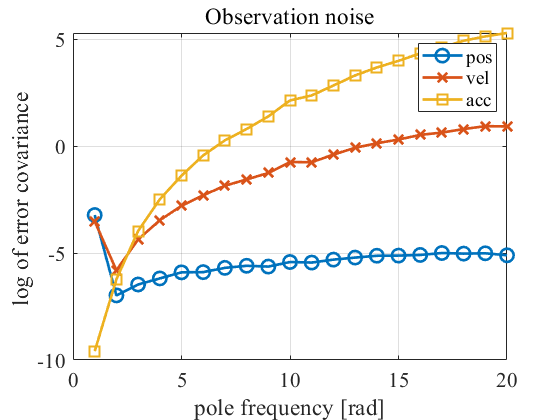

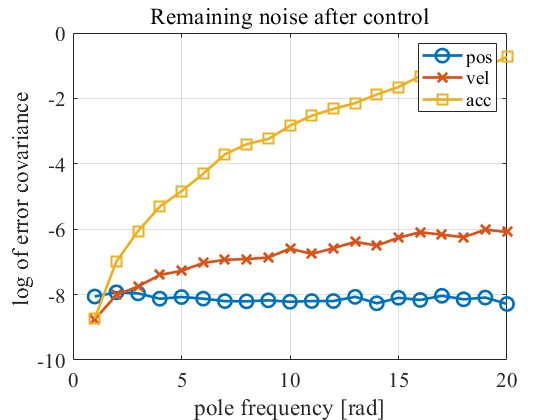

In [92]:
%% Showing
figure(4)
% plot(final_errex(:,1:3))
grid on
plot(lpoles,log(Final_err_real(:,1)),'o-',lpoles,log(Final_err_real(:,2)),'x-',lpoles,log(Final_err_real(:,3)),'s-')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos','vel','acc','best')
title('Remaining noise after control')

figure(5)
% plot(final_errex(:,4:6))
grid on
plot(lpoles,log(Final_err_real(:,4)),'o-',lpoles,log(Final_err_real(:,5)),'x-',lpoles,log(Final_err_real(:,6)),'s-')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos','vel','acc','best')
title('Observation noise')



In [107]:
Final_err_real(:,1)

save('sigma1e-1.mat','Final_err_real')


ans =

   1.0e-03 *

    0.3163
    0.3598
    0.3478
    0.2960
    0.3113
    0.2965
    0.2747
    0.2731
    0.2815
    0.2696
    0.2750
    0.2757
    0.3133
    0.2572
    0.3040
    0.2845
    0.3235
    0.2905
    0.3063
    0.2519




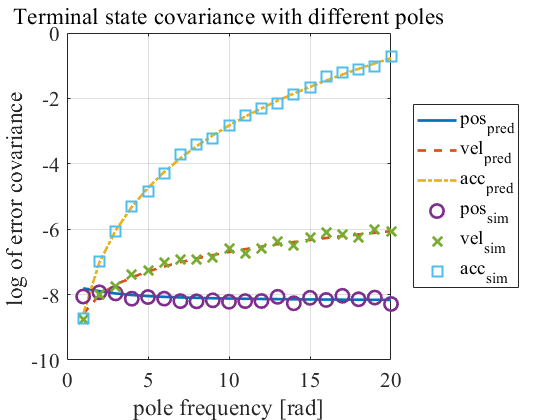

In [93]:
figure(5)
clf
% plot(final_errex(:,4:6))
plot(lpoles,log(final_errex(:,1)),'-',lpoles,log(final_errex(:,2)),'--',lpoles,log(final_errex(:,3)),'-.')
hold on
plot(lpoles,log(Final_err_real(:,1)),'o',lpoles,log(Final_err_real(:,2)),'x',lpoles,log(Final_err_real(:,3)),'s')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos_{pred}','vel_{pred}','acc_{pred}','pos_{sim}','vel_{sim}','acc_{sim}','Location','eastoutside')
title('Terminal state covariance with different poles')
SaveFigPDF(5,'statenoise_sim')

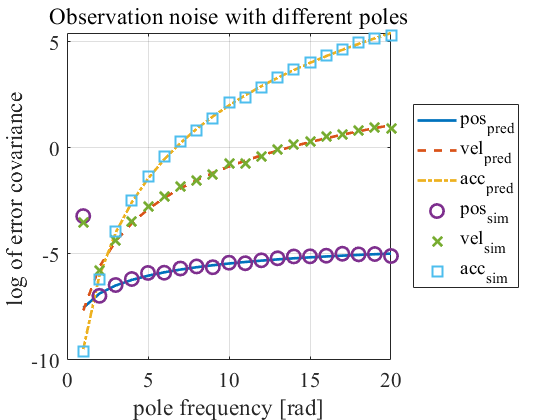

In [94]:
figure(6)
clf
% plot(final_errex(:,4:6))
plot(lpoles,log(final_errex(:,4)),'-',lpoles,log(final_errex(:,5)),'--',lpoles,log(final_errex(:,6)),'-.')
hold on
plot(lpoles,log(Final_err_real(:,4)),'o',lpoles,log(Final_err_real(:,5)),'x',lpoles,log(Final_err_real(:,6)),'s')
grid on
xlabel('pole frequency [rad]')
ylabel('log of error covariance ')
legend('pos_{pred}','vel_{pred}','acc_{pred}','pos_{sim}','vel_{sim}','acc_{sim}','Location','eastoutside')
title('Observation noise with different poles')
SaveFigPDF(6,'obsnoise_sim')

つまるところ，推定器の誤差の評価には成功。


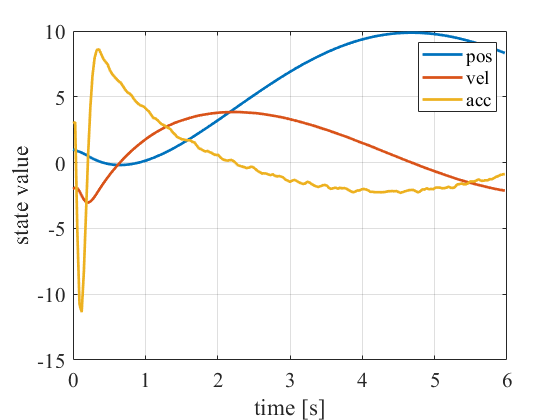

In [85]:
figure(10)
plot(time,x_gt)
grid on
xlabel('time [s]')
ylabel('state value')
legend('pos','vel','acc')

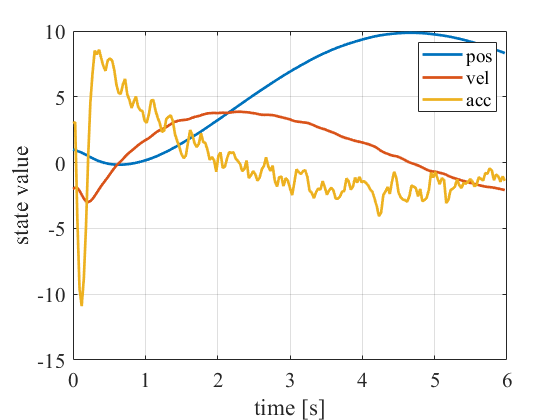

In [95]:
figure(10)
plot(time,x_gt)
grid on
xlabel('time [s]')
ylabel('state value')
legend('pos','vel','acc')

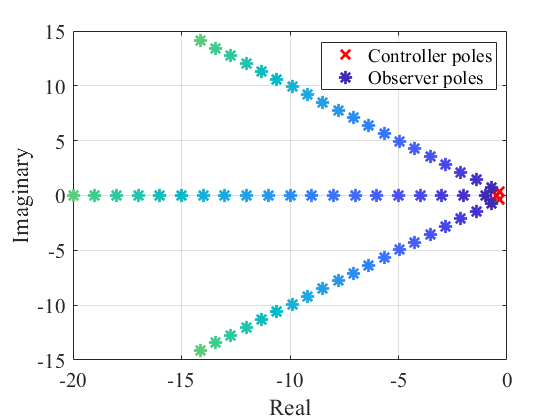

In [97]:
figure(100)
clf
plot(bwbase*-0.5,'rx')
grid on
hold on

cmap = colormap;
for lpoles=1:20
plot(bwbase*-1*lpoles,'*','color',cmap(lpoles*2,:))
end
legend('Controller poles','Observer poles')
xlabel('Real')
ylabel('Imaginary')
SaveFigPDF(100,'polepositions')

In [100]:
[minval,minindex]=min(Final_err_real(:,1))



minval =

   2.5187e-04


minindex =

    20


